In [133]:
#Importing the libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import uncertainties as u 
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy
from lmfit import Minimizer, Parameters, fit_report

In [134]:
# Constants and values

R_I = 10.622 #Ohm

In [135]:
#Reading data

R_1 = pd.read_excel('data/R_1.xlsx')
C_1 = pd.read_excel('data/C_1.xlsx')
L_1 = pd.read_excel('data/L_1.xlsx')

f_2 = pd.read_excel('data/f_2.xlsx')

scope_0 = pd.read_csv('data/scope_0.csv')
scope_1 = pd.read_csv('data/scope_1.csv')
scope_2 = pd.read_csv('data/scope_2.csv')

In [136]:
#Calculations

R_1['U_20'] = R_1['U_20']*10**(-3)
C_1['U_20'] = C_1['U_20']*10**(-3)
L_1['U_20'] = L_1['U_20']*10**(-3)

R_1['Z'] = R_I * R_1['U_M0']/R_1['U_20']
C_1['Z'] = R_I * C_1['U_M0']/C_1['U_20']
L_1['Z'] = R_I * L_1['U_M0']/L_1['U_20']

C_1['C'] = -1/(2*np.pi*C_1['f']*C_1['Z']*np.sin(np.radians(C_1['phi'])))
C_1['R'] = C_1['Z']*np.cos(np.radians(C_1['phi']))

L_1['L'] = L_1['Z']*np.sin(np.radians(L_1['phi']))/(2*np.pi*L_1['f'])
L_1['R'] = L_1['Z']*np.cos(np.radians(L_1['phi']))

print(f'\nResistor\n{R_1}\n')
print(f'\nCondensator\n\n{C_1}\n')
print(f'\nCoil\n{L_1}\n')

R_1_mean = ufloat(R_1['Z'].mean(), np.std(np.array(R_1['Z'])))
C_1_mean = ufloat(C_1['C'].mean(), np.std(np.array(C_1['C'])))
L_1_mean = ufloat(L_1['L'].mean(), np.std(np.array(L_1['L'])))

print('R_1=', R_1_mean)
print('C_1=', C_1_mean)
print('L_1=', L_1_mean)

f_2['U_20'] = f_2['U_20']*10**(-3)

f_2['Z'] = R_I * f_2['U_M0']/f_2['U_20']
f_2['G'] = 1/f_2['Z']
f_2['phi_G'] = -f_2['phi']

print(f'\nRLC\n{f_2}\n')


Resistor
      f   U_M0    U_20  phi          Z
0   100  1.955  0.6991    0  29.703919
1   300  1.955  0.6994    0  29.691178
2   739  1.955  0.6986    0  29.725179
3  1000  1.955  0.6984    0  29.733691
4  3000  1.955  0.6979    0  29.754994


Condensator

      f   U_M0     U_20    phi            Z             C           R
0   100  6.068  0.01673  -88.4  3852.617812  4.132697e-07  107.571403
1   300  6.065  0.04991  -88.5  1290.771990  4.111480e-07   33.788472
2   739  6.023  0.12140  -89.0   526.987694  4.087346e-07    9.197203
3  1000  5.988  0.16140  271.0   394.080149  4.039259e-07    6.877647
4  3000  5.459  0.44100  -89.0   131.486390  4.035378e-07    2.294754


Coil
      f   U_M0     U_20   phi            Z         L          R
0   100  4.297  0.63350  81.5    72.048515  0.113409  10.649449
1   300  5.721  0.28510  87.0   213.147885  0.112923  11.155298
2   739  5.986  0.12110  88.7   525.047828  0.113048  11.911935
3  1000  6.018  0.08890  88.7   719.046074  0.114410  16.3

In [137]:
def G_teor(f_teor, R_teor, L_teor, C_teor):
    omega = 2*np.pi*f_teor
    return 1 / (np.sqrt(R_teor**2 + (omega*L_teor.nominal_value - 1/(omega*C_teor.nominal_value))**2))

def phi_G_teor(f_teor, R_teor, L_teor, C_teor):
    omega = 2*np.pi*f_teor
    return np.degrees(np.arctan((1/(omega*C_teor.nominal_value)-(omega*L_teor.nominal_value))/R_teor))


f_teor = np.linspace(556.100, 969.100, 1000)
R_teor = R_1['Z'][2] + C_1['R'][2] + L_1['R'][2]
L_teor = L_1_mean
C_teor = C_1_mean

alpha_teor = R_teor/(2*L_teor)
omega_teor = 1/sqrt(L_teor*C_teor)
F_teor = 1 / L_teor
Q_teor = (L_teor*omega_teor)/R_teor
f_0_teor = 1/(2*np.pi*sqrt(L_teor*C_teor))


print('alpha_teor=', alpha_teor)
print('omega_teor=', omega_teor)
print('F_teor=', F_teor)
print('Q_teor=', Q_teor)
print('R_celk=', R_teor)
print('f_0_teor=', f_0_teor)

G_teor_values = G_teor(f_teor, R_teor, L_teor, C_teor)
phi_G_teor_values = phi_G_teor(f_teor, R_teor, L_teor, C_teor)

alpha_teor= 223.0+/-2.4
omega_teor= 4636+/-33
F_teor= 8.77+/-0.09
Q_teor= 10.40+/-0.07
R_celk= 50.83431756597476
f_0_teor= 738+/-5


In [138]:
#RLC fit

def Gabs(F,omega0,alpha,omega):
	return omega*F/np.sqrt((omega0**2-omega**2)**2+(2*alpha*omega)**2)
def Gphi(omega0,alpha,omega):  #faze ve stupnich
	return np.arctan((omega0**2-omega**2)/(2*alpha*omega))/np.pi*180
def residual(pars, omega, Gdata):
	return Gabs(pars['F'],pars['omega0'],pars['alpha'],omega) - Gdata 

fdata=f_2['f']
odata=fdata*2*np.pi 
Gdata=f_2['G']
Phase=f_2['phi_G']

R=60
L=0.100
C=500E-9

ParsStart = Parameters()  
ParsStart.add('F', value=1/L,vary=True)   
ParsStart.add('omega0', value=1/np.sqrt(L*C),vary=True)  
ParsStart.add('alpha', value=R/(2*L),vary=True)

minner = Minimizer(residual, ParsStart, fcn_args=(odata,Gdata))
results = minner.minimize() 
ParsFit= results.params 

print(fit_report(results))
# FileStatistika= open('Statistika.dat', 'w+')
# print(fit_report(results),file=FileStatistika)
# FileStatistika.close()

F=ufloat(ParsFit['F'], ParsFit['F'].stderr)  
omega0=ufloat(ParsFit['omega0'], ParsFit['omega0'].stderr)
alpha=ufloat(ParsFit['alpha'], ParsFit['alpha'].stderr)

L=1/F
R=2*L*alpha
C=1/(L*omega0**2)
Q=omega0/(2*alpha)
f0=omega0/(2*np.pi)
print("R=", R,"Ohm, L=", L*1000,"mH, C=", C*1E9,"nF,  Q=",Q, "f0=", f0, "Hz")

ftheor = np.arange(np.amin(fdata), np.amax(fdata), 1)
otheor=ftheor*2*np.pi

GabsStart = Gabs(ParsStart["F"],ParsStart["omega0"],ParsStart["alpha"],otheor)  
GphiStart = Gphi(ParsStart["omega0"],ParsStart["alpha"],otheor) 
GabsFit = Gabs(ParsFit["F"],ParsFit["omega0"],ParsFit["alpha"],otheor)  
GphiFit = Gphi(ParsFit["omega0"],ParsFit["alpha"],otheor) 

# FileFitSpekta= open('FitSpekta.dat', 'w+')
# print ("f[Hz]", "\t", "GabsStart",  "\t", "GphiStart", "\t", "GabsFit",  "\t", "GphiFit", file=FileFitSpekta)
# for i in range(len(ftheor)):
#     print (ftheor[i],"\t",GabsStart[i],  "\t",GphiStart[i], "\t", GabsFit[i],  "\t",GphiFit[i], file=FileFitSpekta)
# FileFitSpekta.close()


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 17
    # variables        = 3
    chi-square         = 1.2774e-07
    reduced chi-square = 9.1243e-09
    Akaike info crit   = -312.010227
    Bayesian info crit = -309.510587
[[Variables]]
    F:       8.67397383 +/- 0.04444649 (0.51%) (init = 10)
    omega0:  4641.92620 +/- 1.01195110 (0.02%) (init = 4472.136)
    alpha:   220.635423 +/- 1.43160382 (0.65%) (init = 300)
[[Correlations]] (unreported correlations are < 0.100)
    C(F, alpha) = +0.9483
R= 50.9+/-0.4 Ohm, L= 115.3+/-0.6 mH, C= 402.6+/-2.1 nF,  Q= 10.52+/-0.07 f0= 738.79+/-0.16 Hz


In [139]:
R_measur = R
omega_measur = omega0
alpha = alpha
L_measur = L*1000
C_measur = C*1E9
F_measur = F
f_0_measur = f0
Q_measur = Q

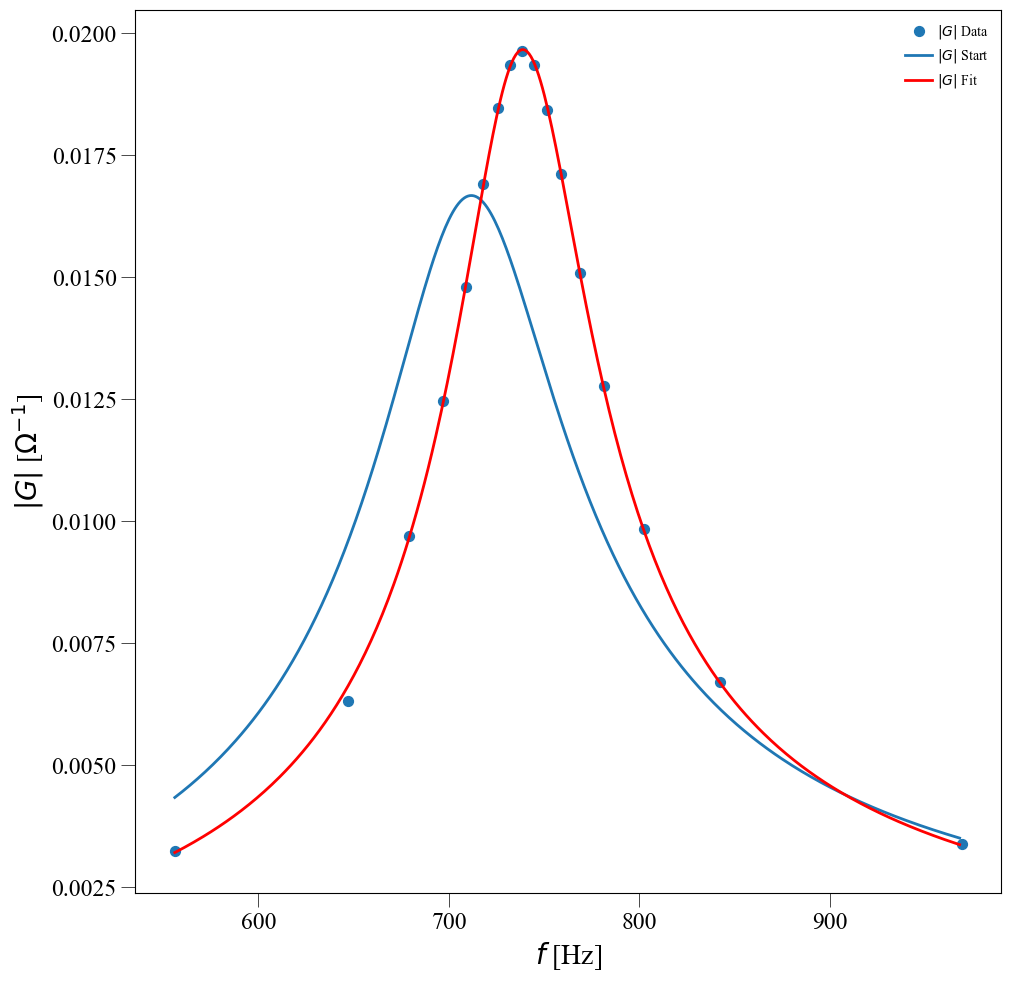

In [140]:
# Plot the data and the best-fit line

colors = ['#FF7F0E','#D62728','#FFDB58','#2CA02C','#17BECF','#1F77B4','#F0027F']  

plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 10))

# ax.title.set_fontsize(20)
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\vert G\vert$ [$\Omega^{-1}$]")
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=17)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=17)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.scatter(f_2['f'], f_2['G'], color=colors[5], marker='o', s=50, label=r'$\vert G\vert$ Data')
ax.plot(ftheor, GabsStart, color=colors[5], linewidth=2, label=r'$\vert G\vert$ Start')
ax.plot(ftheor, GabsFit, color='red', linewidth=2, label=r'$\vert G\vert$ Fit')


# ax.plot(f_teor, G_teor_values, color='red', linewidth=2, label=r'$\vert G\vert$ Theory')
# ax.axhline(y=f_2['G'][8], color='black', linestyle='--', linewidth=1, label=f'1/R')
# ax.axvline(x=f_2['f'][8], color='black', linestyle='-.', linewidth=1, label=f'$\omega_0$') 
# ax.axhline(y=G_alpha, color='black', linestyle=':', linewidth=1)
# ax.axvline(x=693, color='black', linestyle='-.', linewidth=1) 
# ax.axvline(x=790, color='black', linestyle='-.', linewidth=1) 
# plt.annotate('', xy=(693, G_alpha), xytext=(790, G_alpha),
#              arrowprops=dict(arrowstyle='<->', color='black', linewidth=2),
#              annotation_clip=False)

handles, labels = ax.get_legend_handles_labels()
order = [0, 1, 2]

ax.legend([handles[i] for i in order], [labels[i] for i in order]
        ,frameon=False, loc="upper right", 
          # bbox_to_anchor=(1.0, 0.95),
		  fontsize=10, ncol=1, handletextpad=0.3)


plt.show() 

fig.savefig('images/G.png', bbox_inches='tight')

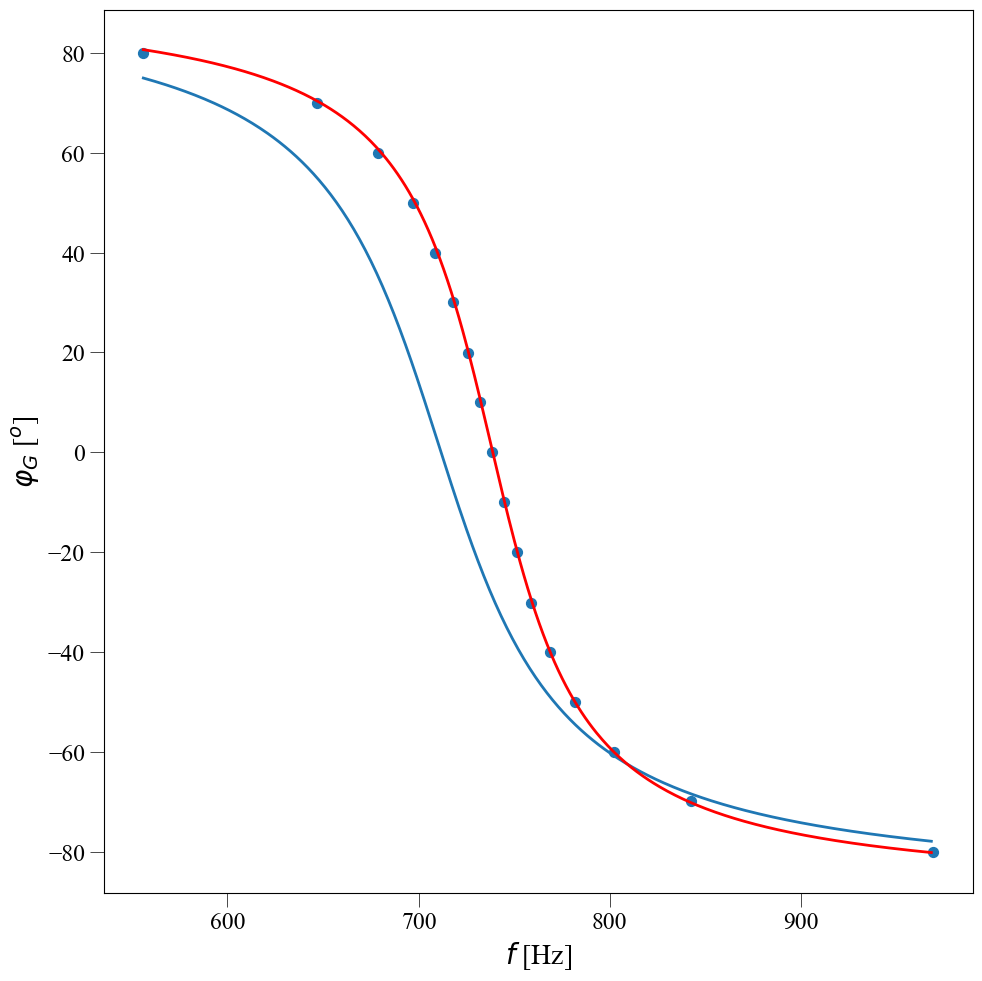

In [141]:
# Plot the data and the best-fit line

colors = ['#FF7F0E','#D62728','#FFDB58','#2CA02C','#17BECF','#1F77B4','#F0027F']  

plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 10))

# ax.title.set_fontsize(20)
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\varphi_G$ [$^o$]")
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=17)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=17)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.scatter(f_2['f'], f_2['phi_G'], color=colors[5], marker='o', s=50, label=r'$\varphi_G$ Data')
ax.plot(ftheor, GphiStart, color=colors[5], linewidth=2, label=r'$\varphi_G$ Start')
ax.plot(ftheor, GphiFit, color='red', linewidth=2, label=r'$\varphi_G$ Fit')

# ax.plot(f_teor, phi_G_teor_values, color='red', linewidth=2, label=r'$\varphi_G$ Theory')
# ax.axvline(x=f_2['f'][8], color='black', linestyle='-.', linewidth=1, label=f'$\omega_0$') 

# handles, labels = ax.get_legend_handles_labels()
# order = [0, 1, 2]

# ax.legend([handles[i] for i in order], [labels[i] for i in order]
#         ,frameon=False, loc="upper right", 
#         #   bbox_to_anchor=(0.068, 1.0),
# 		  fontsize=10, ncol=1, handletextpad=0.3)


plt.show() 

# fig.savefig('images/phi_G.png', bbox_inches='tight')

U_f = -3.07792647


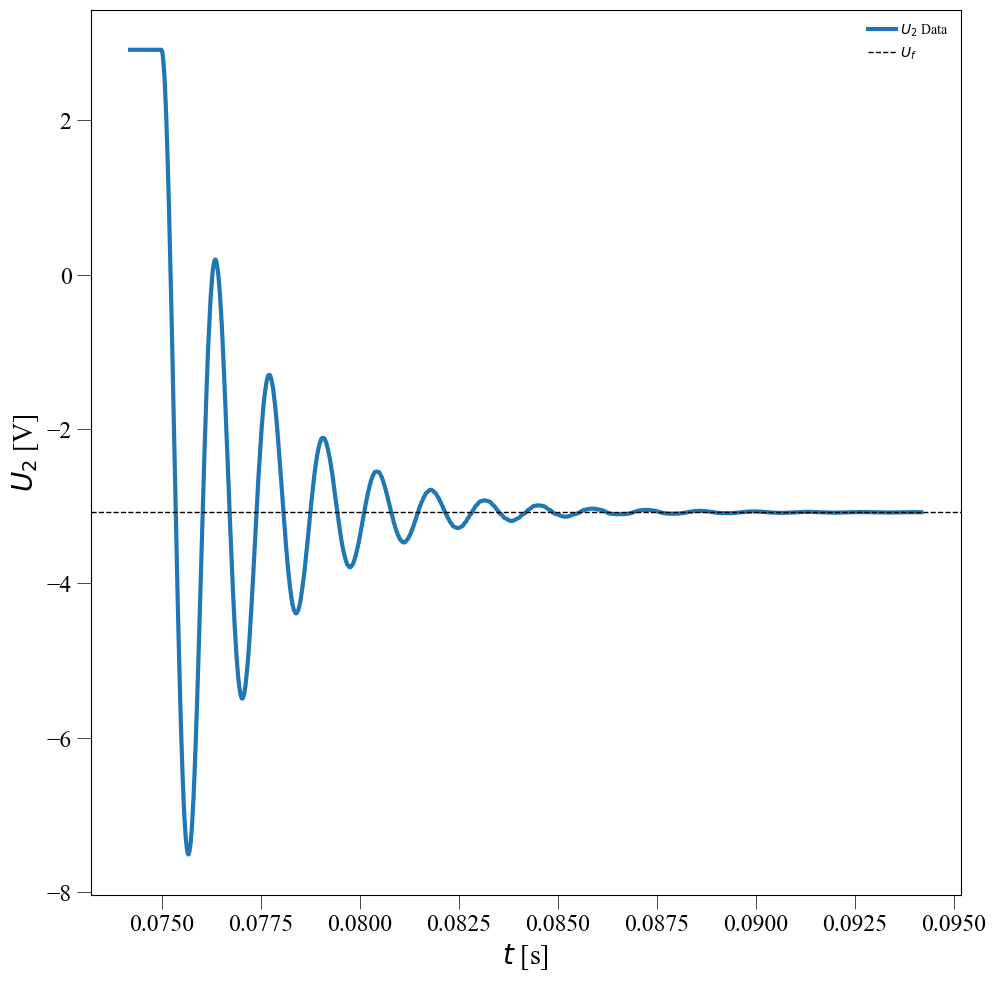

In [142]:
# Plot the data and the best-fit line

colors = ['#FF7F0E','#D62728','#FFDB58','#2CA02C','#17BECF','#1F77B4','#F0027F']  

plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 10))

# ax.title.set_fontsize(20)
ax.set_xlabel(r"$t$ [s]")
ax.set_ylabel(r"$U_2$ [V]")
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=17)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=17)
# plt.xticks(rotation=45)
plt.tight_layout()  

# x = 1032
u_f = scope_0['u_2'][1998]
print('U_f =', u_f)
# print('U_C =', scope_0['u_2'][x])
# print('t_c =', scope_0['t'][x])

# ax.scatter(scope_0['t'], scope_0['u_2'], color=colors[5], marker='o', s=5, label=r'$U_2$ Data')
ax.plot(scope_0['t'], scope_0['u_2'], color=colors[5], linewidth=3, label=r'$U_2$ Data')
ax.axhline(y=scope_0['u_2'][1998], color='black', linestyle='--', linewidth=1, label=r'$U_f$')
# ax.axvline(x=scope_0['t'][x], color='black', linestyle='-', linewidth=1)


handles, labels = ax.get_legend_handles_labels()
order = [0, 1]

ax.legend([handles[i] for i in order], [labels[i] for i in order]
        ,frameon=False, loc="upper right", 
        #   bbox_to_anchor=(0.068, 1.0),
		  fontsize=10, ncol=1, handletextpad=0.3)


plt.show() 

# fig.savefig('images/pod_krit.png', bbox_inches='tight')

In [143]:
# #Linear fitting

u_c_list = [0.18965242, -1.29941085, -2.11729032, -2.5510466, -2.78644109, -2.92356013, -2.98914254]
ln_u_list = np.log(u_c_list-u_f)
t_c_list = [0.07634, 0.0777, 0.07905, 0.08043, 0.0818, 0.08317, 0.08452]

# Calculate linear regression parameters
slope, intercept, r_value, p_value, std_err = stats.linregress(t_c_list, ln_u_list)
alpha_d = ufloat(np.abs(slope), np.abs(std_err))
print('alpha_d =', alpha_d)

# Create the best-fit line
best_fit_line = slope * np.array(t_c_list) + intercept

alpha_d = 442.0+/-2.3


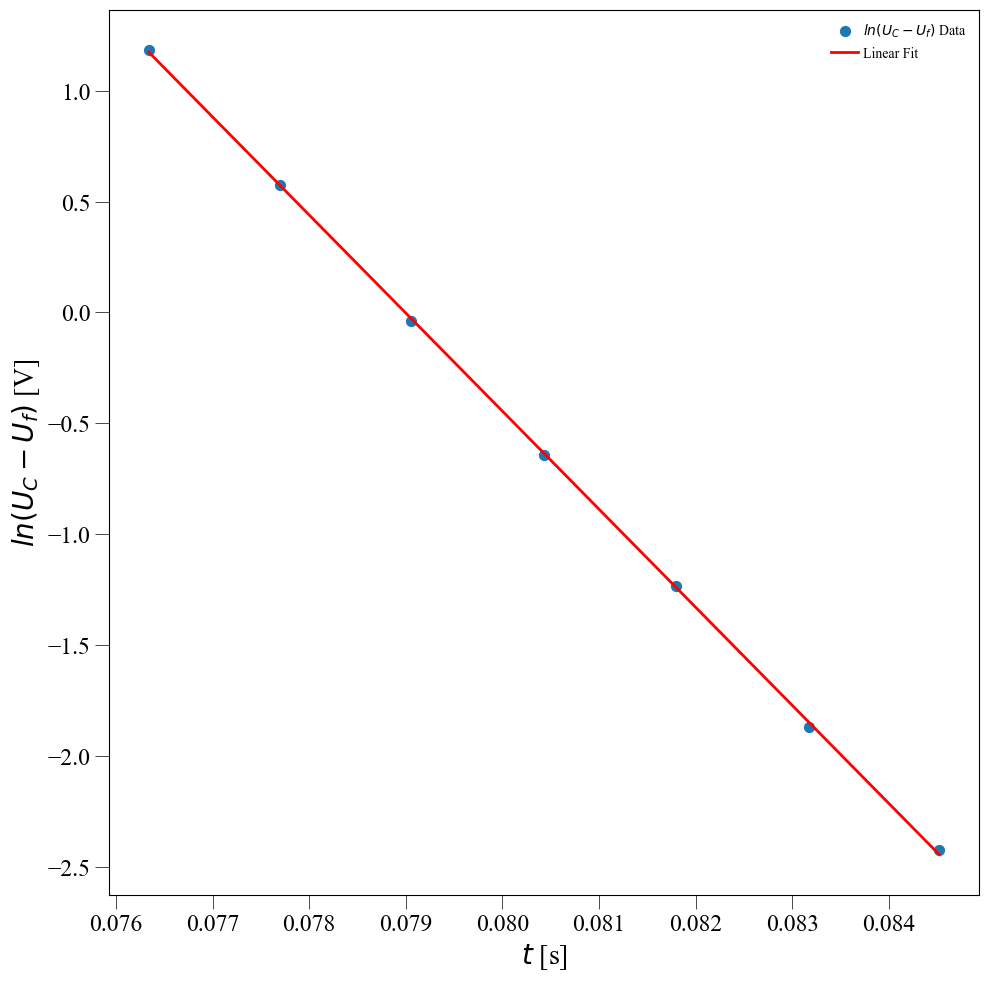

In [144]:
# Plot the data and the best-fit line

colors = ['#FF7F0E','#D62728','#FFDB58','#2CA02C','#17BECF','#1F77B4','#F0027F']  

plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 10))

# ax.title.set_fontsize(20)
ax.set_xlabel(r"$t$ [s]")
ax.set_ylabel(r"$ln(U_C-U_f)$ [V]")
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=17)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=17)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.scatter(t_c_list, ln_u_list, color=colors[5], marker='o', s=50, label=r'$ln(U_C-U_f)$ Data')
ax.plot(t_c_list, best_fit_line, color='red', linewidth=2, label='Linear Fit')

handles, labels = ax.get_legend_handles_labels()
order = [0, 1]

ax.legend([handles[i] for i in order], [labels[i] for i in order]
        ,frameon=False, loc="upper right", 
        #   bbox_to_anchor=(0.068, 1.0),
		  fontsize=10, ncol=1, handletextpad=0.3)


plt.show() 

# fig.savefig('images/pod_krit_fit.png', bbox_inches='tight')

In [145]:
R_G = 50
R_R_1 = 29.12
R_R_2 = 848.8
R_R_3 = 6002

R_1_3 = alpha_d*2*L_1_mean

omega_d = sqrt(omega_measur**2 - alpha_d**2)

f_0_3 = omega_measur / (2 * np.pi)

R_celk_1 = R_R_1 + C_1['R'][2] + L_1['R'][2]
R_celk_2 = R_R_2 + C_1['R'][2] + L_1['R'][2]
R_celk_3 = R_R_3 + C_1['R'][2] + L_1['R'][2]

R_2_3 = 2 * omega_measur * L_1_mean

print('R_celk_1 =', R_celk_1)
print('R_celk_2 =', R_celk_2)
print('R_celk_3 =', R_celk_3)

print('f_0_3 =', f_0_3)
print('R_1_3 =', R_1_3)
print('R_2_3 =', R_2_3)

R_celk_1 = 50.22913863668761
R_celk_2 = 869.9091386366877
R_celk_3 = 6023.109138636688
f_0_3 = 738.79+/-0.16
R_1_3 = 100.8+/-1.2
R_2_3 = 1058+/-11


U_f = -3.04012459


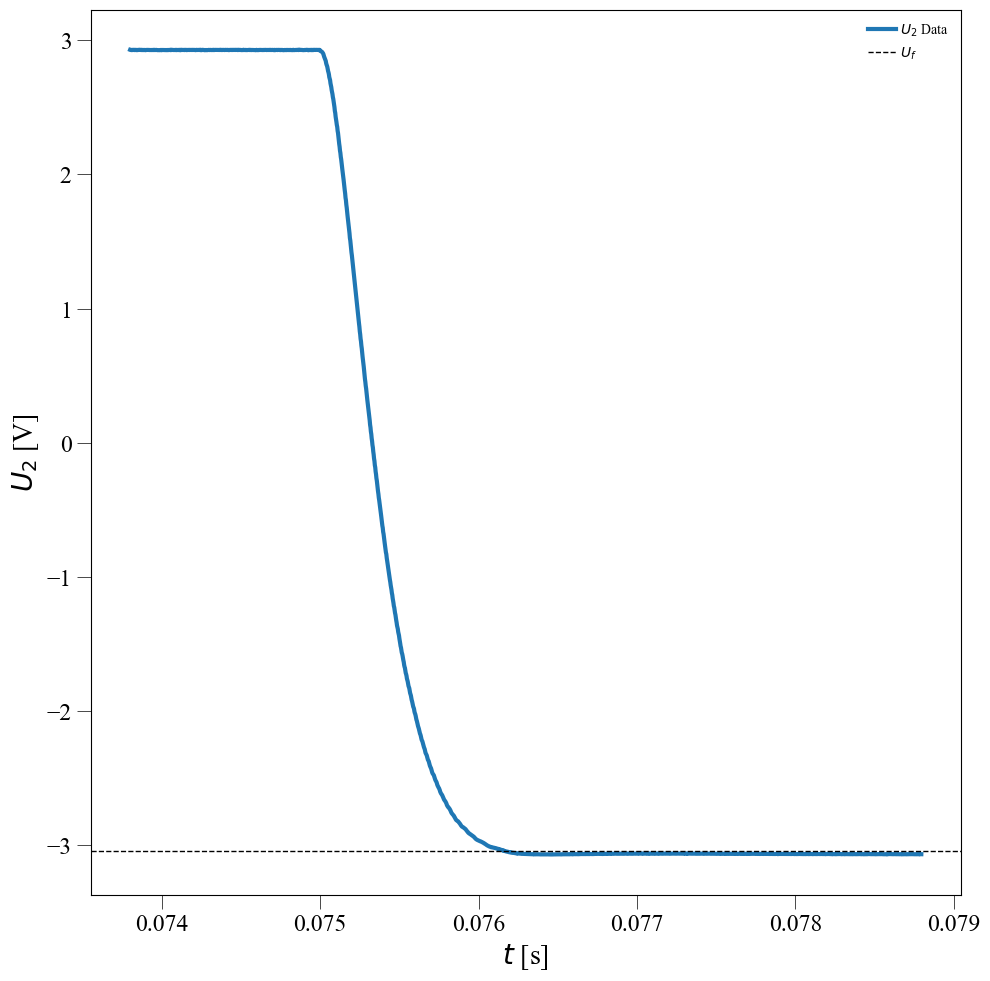

In [146]:
# Plot the data and the best-fit line

colors = ['#FF7F0E','#D62728','#FFDB58','#2CA02C','#17BECF','#1F77B4','#F0027F']  

plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 10))

# ax.title.set_fontsize(20)
ax.set_xlabel(r"$t$ [s]")
ax.set_ylabel(r"$U_2$ [V]")
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=17)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=17)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.plot(scope_1['t'], scope_1['u_2'], color=colors[5], linewidth=3, label=r'$U_2$ Data')
ax.axhline(y=scope_2['u_2'][1360], color='black', linestyle='--', linewidth=1, label=r'$U_f$')

print('U_f =', scope_2['u_2'][1360])


handles, labels = ax.get_legend_handles_labels()
order = [0,1]

ax.legend([handles[i] for i in order], [labels[i] for i in order]
        ,frameon=False, loc="upper right", 
        #   bbox_to_anchor=(0.068, 1.0),
		  fontsize=10, ncol=1, handletextpad=0.3)


plt.show() 

# fig.savefig('images/krit.png', bbox_inches='tight')

In [147]:
#Linear fitting
u_c_list_2 = scope_2['u_2'][443:1397]
u_f_2 = -3.04138675

ln_u_list_2 = np.log(u_c_list_2 - u_f_2)

# Calculate linear regression parameters
slope, intercept, r_value, p_value, std_err = stats.linregress(scope_2['t'][443:1397], ln_u_list_2)
lambda_1 = ufloat(np.abs(slope), np.abs(std_err))
print('lambda_1 =', lambda_1)

# Create the best-fit line
best_fit_line = slope * np.array(scope_2['t'][443:1397]) + intercept

lambda_1 = 350.6+/-1.2


In [148]:
R_3_3 = -L_1_mean * ((omega_measur**2 + lambda_1**2) / lambda_1) 

print('R_3_3 =', R_3_3)

R_3_3 = (-7.05+/-0.08)e+03


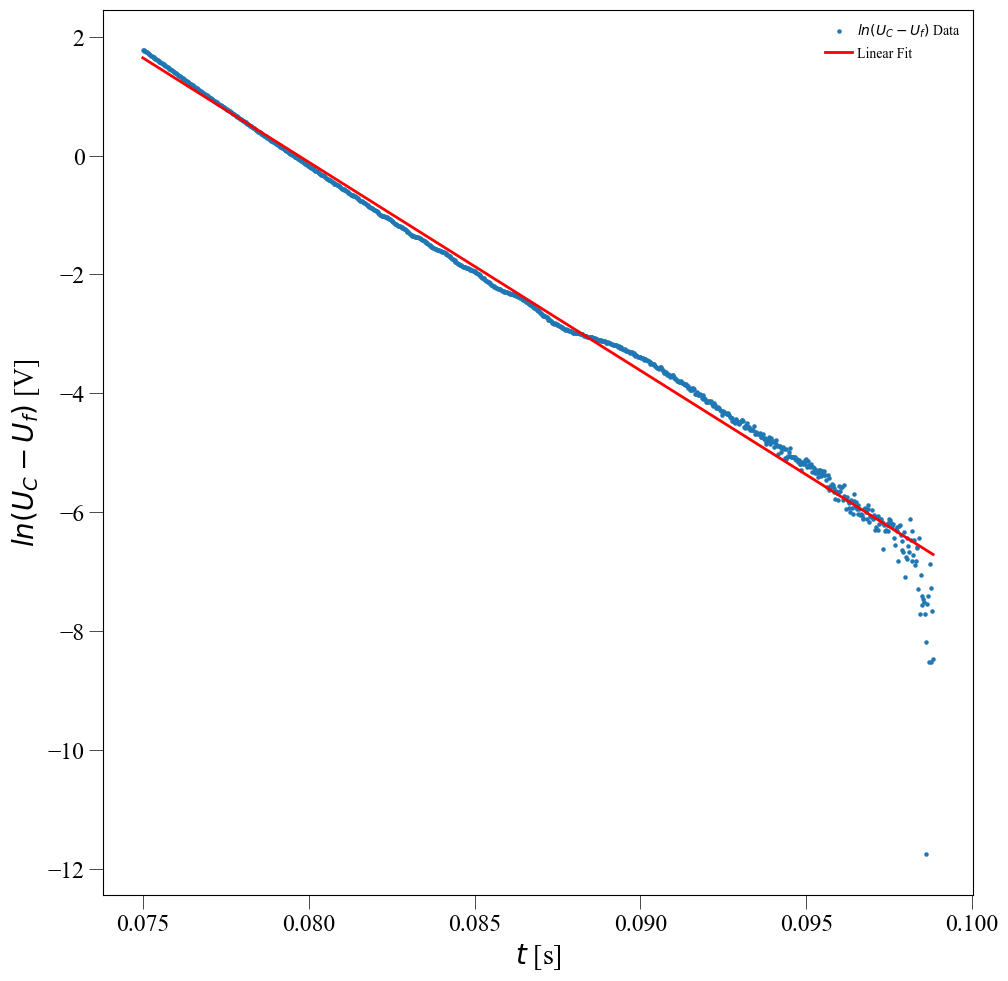

In [149]:
# Plot the data and the best-fit line

colors = ['#FF7F0E','#D62728','#FFDB58','#2CA02C','#17BECF','#1F77B4','#F0027F']  

plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 10))

# ax.title.set_fontsize(20)
ax.set_xlabel(r"$t$ [s]")
ax.set_ylabel(r"$ln(U_C-U_f)$ [V]")
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=17)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=17)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.scatter(scope_2['t'][443:1397], ln_u_list_2, color=colors[5], marker='o', s=5, label=r'$ln(U_C-U_f)$ Data')
ax.plot(scope_2['t'][443:1397], best_fit_line, color='red', linewidth=2, label='Linear Fit')

handles, labels = ax.get_legend_handles_labels()
order = [0, 1]

ax.legend([handles[i] for i in order], [labels[i] for i in order]
        ,frameon=False, loc="upper right", 
#         #   bbox_to_anchor=(0.068, 1.0),
		  fontsize=10, ncol=1, handletextpad=0.3)


plt.show() 

# fig.savefig('images/nad_krit_fit.png', bbox_inches='tight')

U_f = -3.03574276


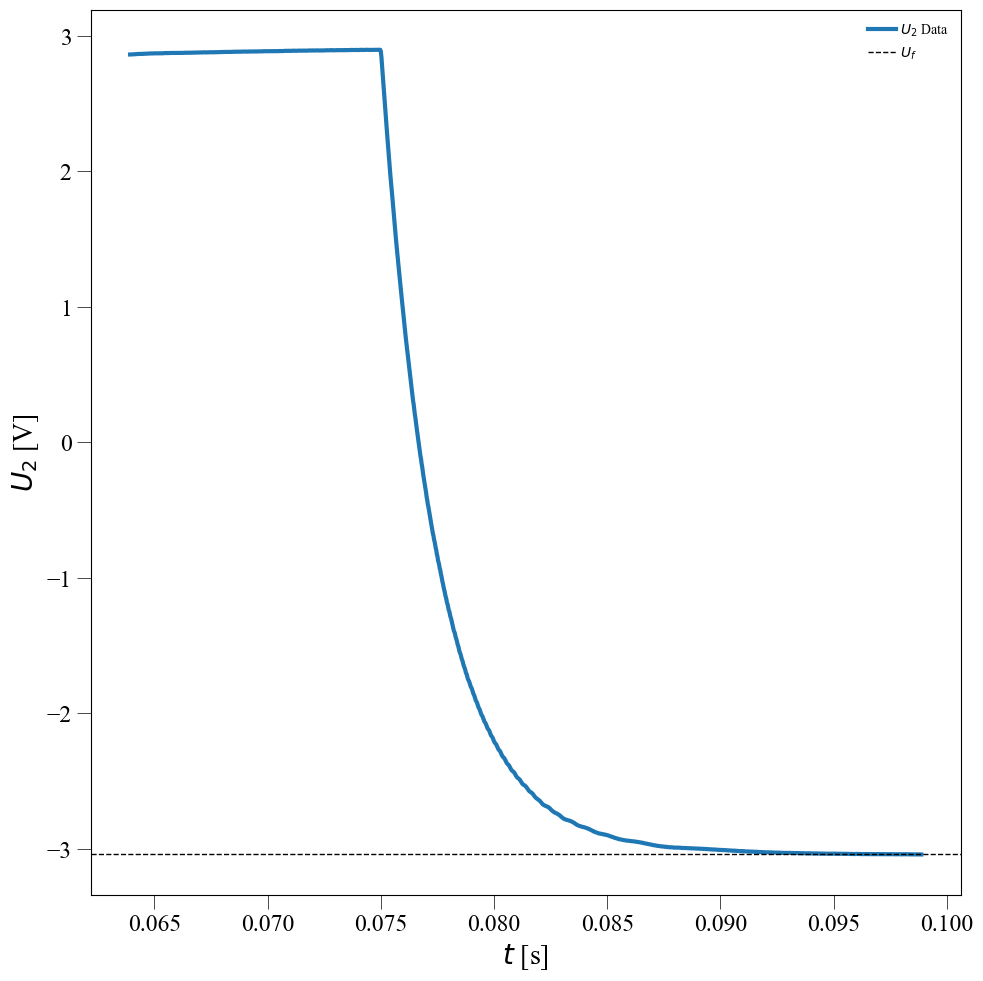

In [150]:
# Plot the data and the best-fit line

colors = ['#FF7F0E','#D62728','#FFDB58','#2CA02C','#17BECF','#1F77B4','#F0027F']  

plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 10))

# ax.title.set_fontsize(20)
ax.set_xlabel(r"$t$ [s]")
ax.set_ylabel(r"$U_2$ [V]")
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=17)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=17)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.plot(scope_2['t'], scope_2['u_2'], color=colors[5], linewidth=3, label=r'$U_2$ Data')
ax.axhline(y=scope_2['u_2'][1240], color='black', linestyle='--', linewidth=1, label=r'$U_f$')

print('U_f =', scope_2['u_2'][1240])

handles, labels = ax.get_legend_handles_labels()
order = [0,1]

ax.legend([handles[i] for i in order], [labels[i] for i in order]
        ,frameon=False, loc="upper right", 
        #   bbox_to_anchor=(0.068, 1.0),
		  fontsize=10, ncol=1, handletextpad=0.3)


plt.show() 

# fig.savefig('images/nad_krit.png', bbox_inches='tight')